# Tutorial 2: Iterative FFT Matching - Frequency-Domain Spectral Matching

**Duration:** ~40-50 minutes

## Learning Objectives

By the end of this tutorial, you will understand:

1. **The frequency-domain approach** to spectral matching
2. **How the FFT algorithm works** step-by-step
3. **Key parameters** and their effects on matching quality
4. **When to use FFT matching** vs other methods
5. **Practical implementation** with real earthquake data

---

## Prerequisites

- Complete Tutorial 1 (Introduction and Fundamentals)
- Understand response spectra concept
- Basic familiarity with Fourier transforms (will be explained)

---

## Section 1: The Frequency-Domain Approach - Core Intuition

### The Big Idea

In Tutorial 1, we saw that simple scaling doesn't work because it affects all frequencies equally. The Iterative FFT method solves this by:

1. **Transform** the acceleration to the frequency domain
2. **Adjust** different frequencies independently based on spectral mismatch
3. **Transform back** to the time domain
4. **Repeat** until convergence

**Analogy:** Think of an audio equalizer:
- You can boost bass (low frequencies) and reduce treble (high frequencies) independently
- FFT matching is like a sophisticated equalizer for earthquake records
- Different "frequency bands" are adjusted to match the target response

### Why the Frequency Domain?

**Fourier's insight:** Any signal can be decomposed into a sum of sine waves at different frequencies.

```
Time Domain              Frequency Domain
                  FFT
a(t)   ──────────────►   A(f)
                 IFFT
       ◄──────────────
```

In the frequency domain:
- Each frequency component is independent
- We can amplify or reduce specific frequency ranges
- Adjustments are straightforward multiplications

---

## Setup: Import Libraries and Load Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.signal.windows import tukey
from scipy.interpolate import interp1d
import sys
import os

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 1.5

# Add the spectral_matching package
sys.path.insert(0, os.path.abspath('../src'))

from spectral_matching import (
    load_acceleration_record,
    load_target_spectrum,
    response_spectrum,
    iterative_fft_match,
    baseline_correction,
    scale_to_target_band,
    arias_intensity,
    cumulative_absolute_velocity
)

print("✓ Libraries loaded!")

✓ Libraries loaded!


In [3]:
# Load El Centro earthquake and target spectrum
time, acceleration, dt = load_acceleration_record("../src/data/elcentro_NS.dat.txt")
acceleration = baseline_correction(acceleration, time, order=2)

# Define period grid
periods = np.linspace(0.05, 3.0, 300)
periods_target, target_spectrum = load_target_spectrum("../src/data/uhs_el_centro.csv", periods)

# Scale to target band as preprocessing
period_band = [0.2, 1.0]
acceleration_scaled, scale_factor = scale_to_target_band(
    acceleration, dt, periods, target_spectrum, band=period_band
)

print(f"✓ Data loaded and preprocessed")
print(f"  Scale factor applied: {scale_factor:.3f}")
print(f"  Target period band: {period_band[0]}-{period_band[1]}s")

✓ Data loaded and preprocessed
  Scale factor applied: 1.109
  Target period band: 0.2-1.0s


---

## Section 2: FFT Fundamentals - Quick Overview

### What is the Fast Fourier Transform?

The FFT converts a time-domain signal into its frequency components:

**Time domain:** $a(t)$ - acceleration at each time $t$

**Frequency domain:** $A(f)$ - amplitude and phase at each frequency $f$

### Visualizing FFT

In [4]:
# Apply FFT to the scaled acceleration
n = len(acceleration_scaled)
n_fft = 2 ** int(np.ceil(np.log2(n)))  # Next power of 2 for efficiency

# Pad to n_fft length
acc_padded = np.zeros(n_fft)
acc_padded[:n] = acceleration_scaled

# Compute FFT (using real FFT for real-valued signals)
fft_coefficients = np.fft.rfft(acc_padded)
frequencies = np.fft.rfftfreq(n_fft, dt)

# Compute magnitude spectrum
magnitude = np.abs(fft_coefficients)

print(f"Signal length: {n} points")
print(f"FFT length (padded): {n_fft} points")
print(f"Number of frequency bins: {len(frequencies)}")
print(f"Frequency resolution: {frequencies[1] - frequencies[0]:.4f} Hz")

Signal length: 2688 points
FFT length (padded): 4096 points
Number of frequency bins: 2049
Frequency resolution: 0.0122 Hz


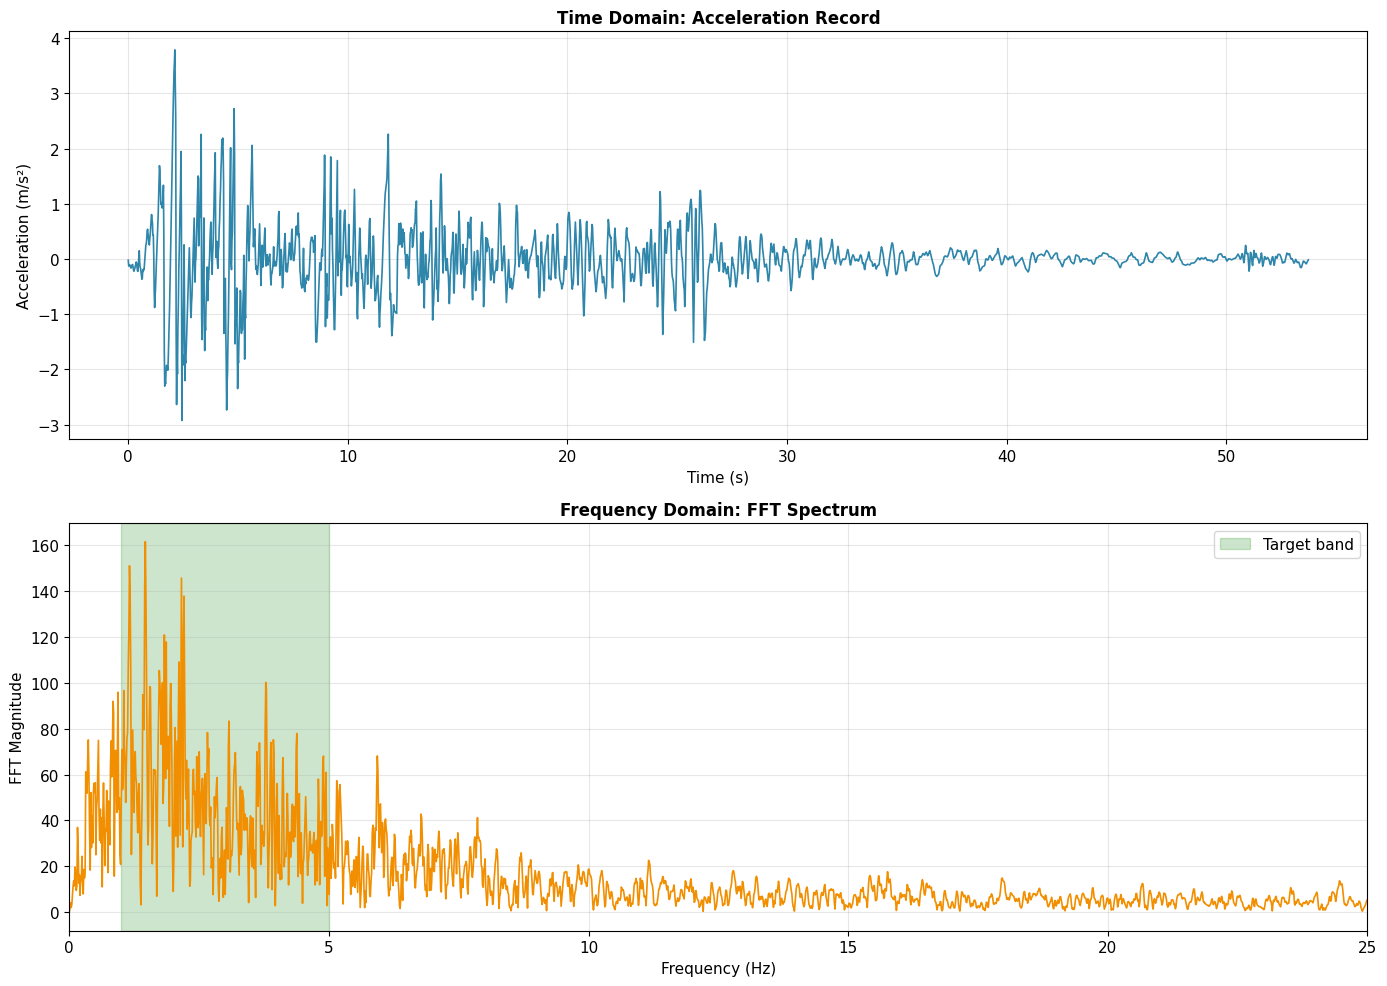


💡 Key Observations:
- Most energy is concentrated in 0-10 Hz (periods > 0.1s)
- Target period band 0.2-1.0s corresponds to 1.0-5.0 Hz
- FFT allows us to adjust specific frequency ranges independently


In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time domain
axes[0].plot(time, acceleration_scaled, color='#2E86AB', linewidth=1.2)
axes[0].set_xlabel('Time (s)', fontsize=11)
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Time Domain: Acceleration Record', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Frequency domain (log scale for better visualization)
axes[1].plot(frequencies, magnitude, color='#F18F01', linewidth=1.2)
axes[1].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1].set_ylabel('FFT Magnitude', fontsize=11)
axes[1].set_title('Frequency Domain: FFT Spectrum', fontsize=12, fontweight='bold')
axes[1].set_xlim([0, 25])  # Focus on relevant frequencies (0-25 Hz)
axes[1].grid(True, alpha=0.3)

# Mark the target period band in frequency space
freq_low = 1.0 / period_band[1]  # 1/1.0s = 1 Hz
freq_high = 1.0 / period_band[0]  # 1/0.2s = 5 Hz
axes[1].axvspan(freq_low, freq_high, alpha=0.2, color='green', label='Target band')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print(f"- Most energy is concentrated in 0-10 Hz (periods > 0.1s)")
print(f"- Target period band 0.2-1.0s corresponds to {freq_low:.1f}-{freq_high:.1f} Hz")
print(f"- FFT allows us to adjust specific frequency ranges independently")

---

## Section 3: The Iterative FFT Algorithm - Step by Step

### Algorithm Overview

```
Initialize: acceleration = scaled_acceleration

FOR iteration = 1 to num_iterations:
    
    Step 1: Compute current response spectrum
    Step 2: Calculate gain ratio = target / current
    Step 3: Map period-domain ratios to frequency grid
    Step 4: Smooth and clip gains for stability
    Step 5: Apply gains in frequency domain (FFT)
    Step 6: Transform back to time domain (IFFT)
    
    acceleration = modified_acceleration
    
END FOR
```

### Manual Implementation of One Iteration

Let's manually implement one iteration to understand each step.

#### Step 1: Compute Current Response Spectrum

In [6]:
# Start with the scaled acceleration
acc_current = acceleration_scaled.copy()

# Compute current response spectrum
spectrum_current = response_spectrum(acc_current, dt, periods, damping=0.05)

print("Step 1: Current response spectrum computed")
print(f"  Spectral acceleration range: {np.min(spectrum_current):.2f} - {np.max(spectrum_current):.2f} m/s²")

Step 1: Current response spectrum computed
  Spectral acceleration range: 1.25 - 10.02 m/s²


#### Step 2: Calculate Gain Ratio

The **gain ratio** tells us how much to adjust each frequency:

$$\text{ratio}(T) = \frac{S_a^{\text{target}}(T)}{S_a^{\text{current}}(T) + \epsilon}$$

Where:
- ratio > 1: Need to amplify this frequency
- ratio < 1: Need to reduce this frequency
- $\epsilon$: Small number to avoid division by zero

In [7]:
# Calculate ratio with clipping to prevent extreme values
eps = 1e-12  # Small epsilon to avoid division by zero
ratio = target_spectrum / (spectrum_current + eps)

# Clip ratio to reasonable range (prevents instability)
ratio_clip_min = 0.4
ratio_clip_max = 4.0
ratio_clipped = np.clip(ratio, ratio_clip_min, ratio_clip_max)

print("Step 2: Gain ratios calculated")
print(f"  Ratio range (before clipping): {np.min(ratio):.3f} - {np.max(ratio):.3f}")
print(f"  Ratio range (after clipping): {np.min(ratio_clipped):.3f} - {np.max(ratio_clipped):.3f}")
print(f"  Clipped {np.sum(ratio != ratio_clipped)} values out of {len(ratio)}")

Step 2: Gain ratios calculated
  Ratio range (before clipping): 0.757 - 2.598
  Ratio range (after clipping): 0.757 - 2.598
  Clipped 0 values out of 300


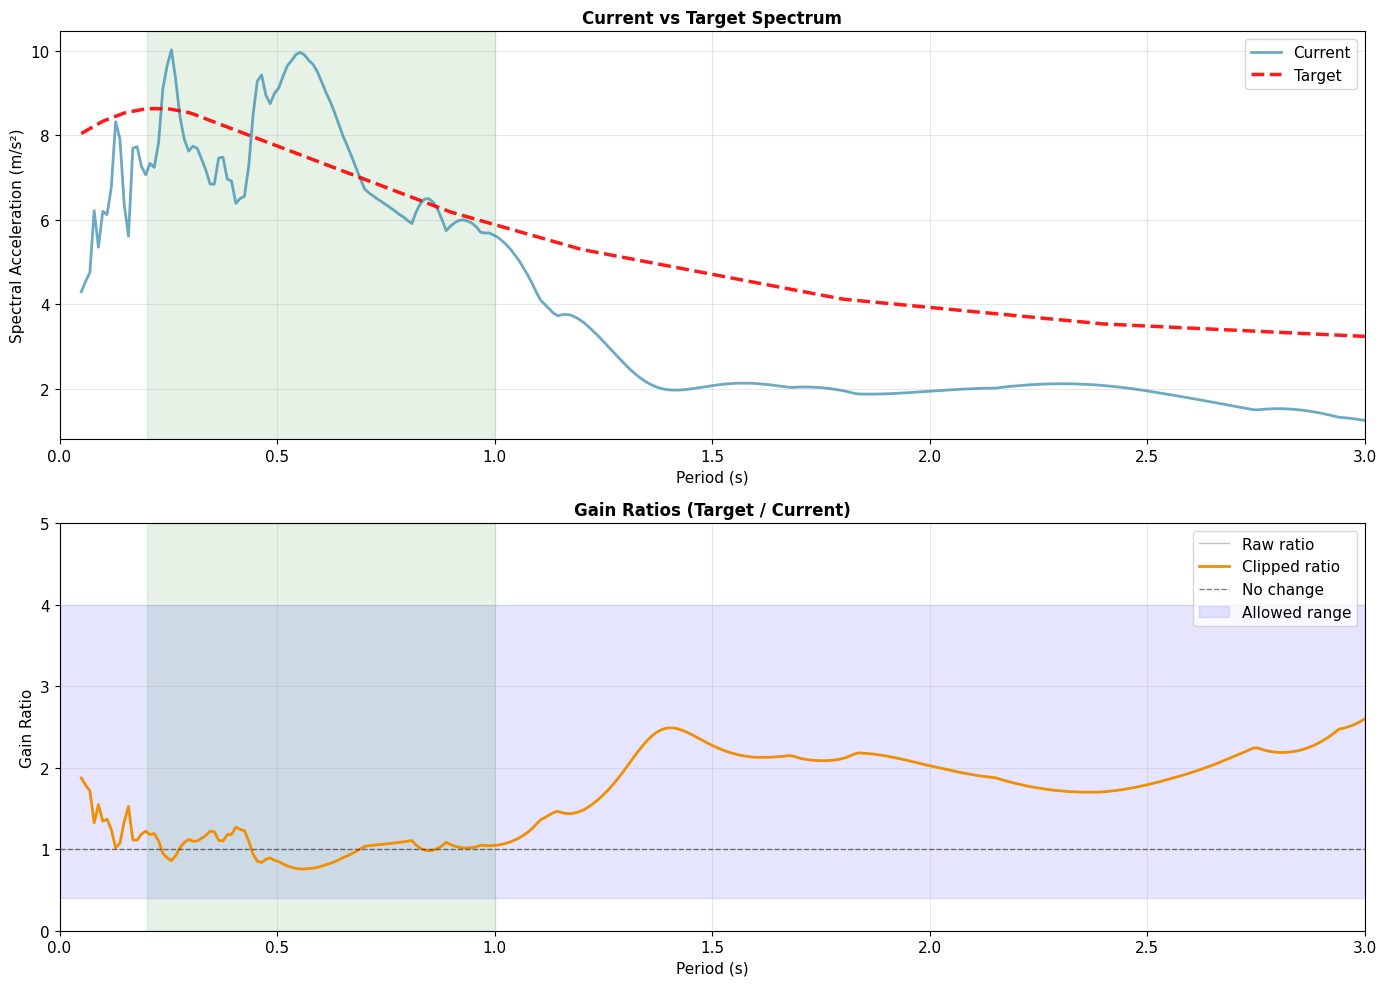


💡 Interpretation:
- Regions where ratio > 1: Need to amplify (current < target)
- Regions where ratio < 1: Need to reduce (current > target)
- Clipping prevents extreme adjustments that could cause instability


In [8]:
# Visualize the gain ratios
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: Spectra comparison
axes[0].plot(periods, spectrum_current, color='#2E86AB', linewidth=2, label='Current', alpha=0.7)
axes[0].plot(periods, target_spectrum, 'r--', linewidth=2.5, label='Target', alpha=0.9)
axes[0].axvspan(period_band[0], period_band[1], alpha=0.1, color='green')
axes[0].set_xlabel('Period (s)', fontsize=11)
axes[0].set_ylabel('Spectral Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Current vs Target Spectrum', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 3])

# Bottom: Gain ratios
axes[1].plot(periods, ratio, color='gray', linewidth=1, label='Raw ratio', alpha=0.5)
axes[1].plot(periods, ratio_clipped, color='#F18F01', linewidth=2, label='Clipped ratio')
axes[1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='No change')
axes[1].axhspan(ratio_clip_min, ratio_clip_max, alpha=0.1, color='blue', label='Allowed range')
axes[1].axvspan(period_band[0], period_band[1], alpha=0.1, color='green')
axes[1].set_xlabel('Period (s)', fontsize=11)
axes[1].set_ylabel('Gain Ratio', fontsize=11)
axes[1].set_title('Gain Ratios (Target / Current)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 3])
axes[1].set_ylim([0, 5])

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("- Regions where ratio > 1: Need to amplify (current < target)")
print("- Regions where ratio < 1: Need to reduce (current > target)")
print("- Clipping prevents extreme adjustments that could cause instability")

#### Step 3: Map Period-Domain Ratios to Frequency Grid

The gain ratios are defined for periods (time-like), but FFT works with frequencies:

$$f = \frac{1}{T}$$

We need to interpolate the ratios onto the FFT frequency grid.

In [9]:
# Convert periods to frequencies (sort in ascending order)
frequency_centers = 1.0 / periods[::-1]  # Reverse for ascending frequency
ratio_for_interp = ratio_clipped[::-1]   # Reverse correspondingly

# Create gain array for FFT frequencies
n = len(acc_current)
n_fft = 2 ** int(np.ceil(np.log2(n)))
fft_frequencies = np.fft.rfftfreq(n_fft, dt)

# Initialize gain as 1.0 (no change) everywhere
gain = np.ones(len(fft_frequencies))

# Only adjust frequencies within the target period band
freq_low = 1.0 / period_band[1]
freq_high = 1.0 / period_band[0]
band_mask = (fft_frequencies >= freq_low) & (fft_frequencies <= freq_high)

# Interpolate ratios to FFT frequency grid (only in band)
interp_func = interp1d(frequency_centers, ratio_for_interp, kind='linear', 
                      bounds_error=False, fill_value=1.0)
gain[band_mask] = interp_func(fft_frequencies[band_mask])

print("Step 3: Gains mapped to frequency grid")
print(f"  FFT frequency points: {len(fft_frequencies)}")
print(f"  Frequencies in target band: {np.sum(band_mask)} / {len(fft_frequencies)}")
print(f"  Gain range: {np.min(gain):.3f} - {np.max(gain):.3f}")

Step 3: Gains mapped to frequency grid
  FFT frequency points: 2049
  Frequencies in target band: 328 / 2049
  Gain range: 0.757 - 1.270


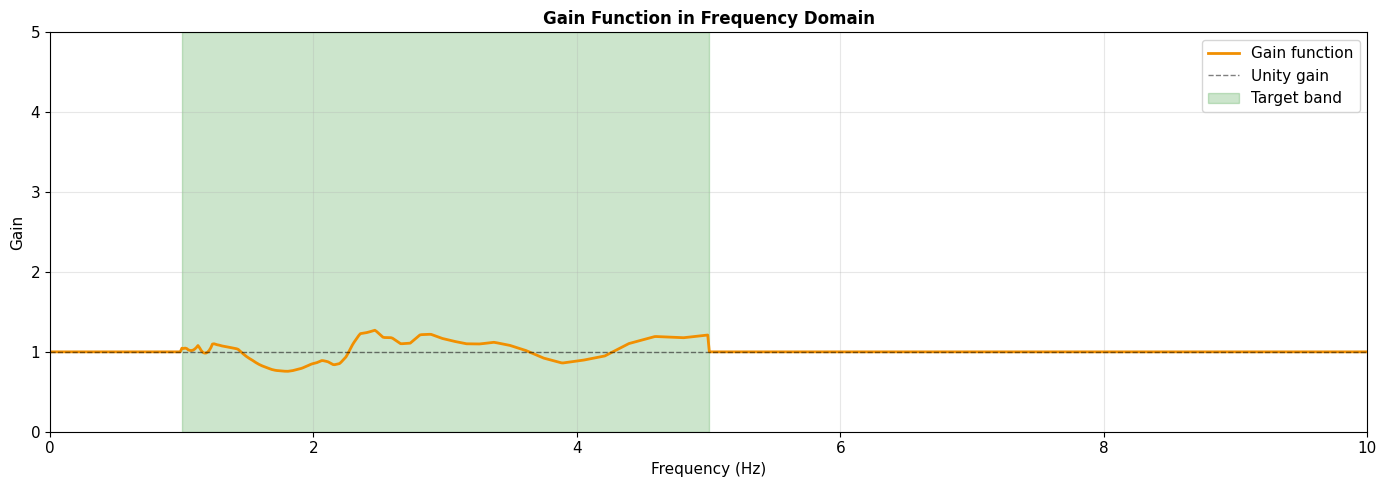


💡 Key Feature:
Frequencies outside 1.0-5.0 Hz have gain = 1.0 (unchanged)
Only the target period band is adjusted


In [10]:
# Visualize gain function in frequency domain
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(fft_frequencies, gain, color='#F18F01', linewidth=2, label='Gain function')
ax.axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Unity gain')
ax.axvspan(freq_low, freq_high, alpha=0.2, color='green', label='Target band')
ax.set_xlabel('Frequency (Hz)', fontsize=11)
ax.set_ylabel('Gain', fontsize=11)
ax.set_title('Gain Function in Frequency Domain', fontsize=12, fontweight='bold')
ax.set_xlim([0, 10])
ax.set_ylim([0, 5])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Key Feature:")
print(f"Frequencies outside {freq_low:.1f}-{freq_high:.1f} Hz have gain = 1.0 (unchanged)")
print(f"Only the target period band is adjusted")

#### Step 4: Smooth and Clip Gains

**Why smooth?** Sharp changes in the frequency domain create oscillations ("ringing") in the time domain.

**Solution:** Apply a moving average filter to smooth the gain function.

In [11]:
# Smoothing parameters
smooth_width = 15  # Width of smoothing window

# Apply moving average smoothing
if smooth_width > 1:
    kernel = np.ones(smooth_width) / smooth_width
    gain_smoothed = convolve(gain, kernel, mode='same')
else:
    gain_smoothed = gain.copy()

# Apply final clipping to smoothed gain
gain_clip_min = 0.3
gain_clip_max = 4.0
gain_final = np.clip(gain_smoothed, gain_clip_min, gain_clip_max)

print("Step 4: Gain smoothing and clipping")
print(f"  Smoothing window: {smooth_width} points")
print(f"  Gain range (before smoothing): {np.min(gain):.3f} - {np.max(gain):.3f}")
print(f"  Gain range (after smoothing): {np.min(gain_smoothed):.3f} - {np.max(gain_smoothed):.3f}")
print(f"  Gain range (after final clipping): {np.min(gain_final):.3f} - {np.max(gain_final):.3f}")

Step 4: Gain smoothing and clipping
  Smoothing window: 15 points
  Gain range (before smoothing): 0.757 - 1.270
  Gain range (after smoothing): 0.533 - 1.239
  Gain range (after final clipping): 0.533 - 1.239


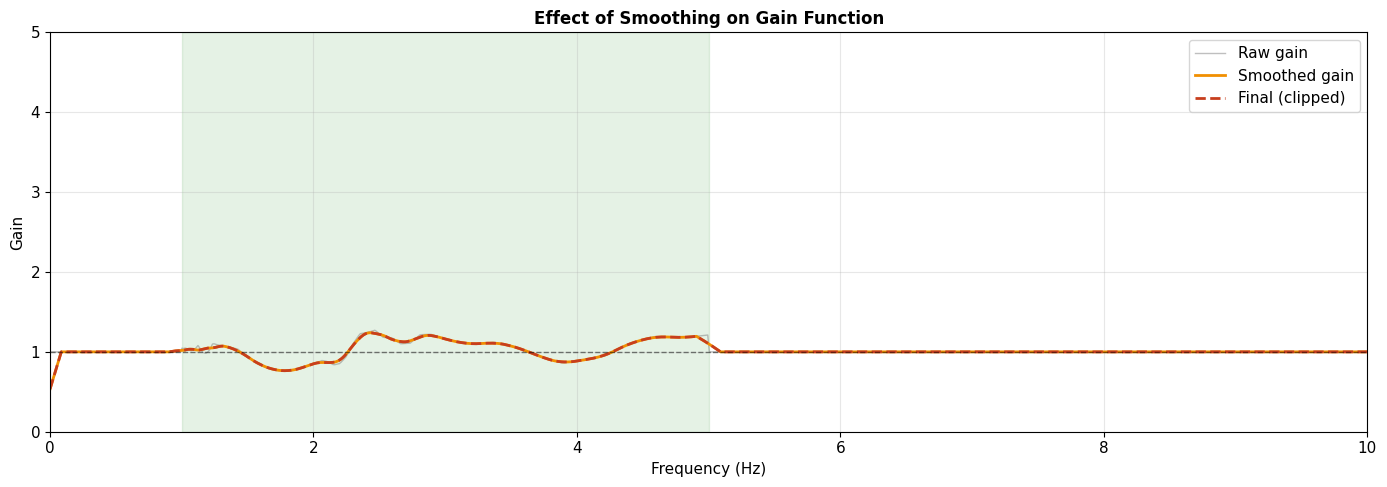


💡 Why This Matters:
Smoothing removes sharp transitions that would create time-domain artifacts
The result is a more physically realistic modified ground motion


In [12]:
# Compare unsmoothed vs smoothed gains
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(fft_frequencies, gain, color='gray', linewidth=1, alpha=0.5, label='Raw gain')
ax.plot(fft_frequencies, gain_smoothed, color='#F18F01', linewidth=2, label='Smoothed gain')
ax.plot(fft_frequencies, gain_final, color='#C73E1D', linewidth=2, linestyle='--', label='Final (clipped)')
ax.axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.axvspan(freq_low, freq_high, alpha=0.1, color='green')
ax.set_xlabel('Frequency (Hz)', fontsize=11)
ax.set_ylabel('Gain', fontsize=11)
ax.set_title('Effect of Smoothing on Gain Function', fontsize=12, fontweight='bold')
ax.set_xlim([0, 10])
ax.set_ylim([0, 5])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Why This Matters:")
print("Smoothing removes sharp transitions that would create time-domain artifacts")
print("The result is a more physically realistic modified ground motion")

#### Step 5: Apply Gains in Frequency Domain

Now we apply the gains by:
1. Windowing the acceleration (tapering edges)
2. Computing FFT
3. Multiplying by gain
4. Computing inverse FFT

In [13]:
# Step 5a: Apply Tukey window (reduces edge effects)
tukey_alpha = 0.1  # 10% tapering at each end
window = tukey(len(acc_current), alpha=tukey_alpha)
acc_windowed = acc_current * window

# Step 5b: Pad and compute FFT
acc_padded = np.zeros(n_fft)
acc_padded[:len(acc_current)] = acc_windowed
fft_coefficients = np.fft.rfft(acc_padded)

# Step 5c: Apply gain (multiplication in frequency domain)
fft_modified = fft_coefficients * gain_final

# Step 5d: Inverse FFT to get modified acceleration
acc_modified_full = np.fft.irfft(fft_modified, n=n_fft)
acc_modified = acc_modified_full[:len(acc_current)]

print("Step 5: Frequency-domain modification completed")
print(f"  Original PGA: {np.max(np.abs(acc_current)):.3f} m/s²")
print(f"  Modified PGA: {np.max(np.abs(acc_modified)):.3f} m/s²")
print(f"  Change: {(np.max(np.abs(acc_modified)) / np.max(np.abs(acc_current)) - 1) * 100:.1f}%")

Step 5: Frequency-domain modification completed
  Original PGA: 3.786 m/s²
  Modified PGA: 3.405 m/s²
  Change: -10.1%


#### Step 6: Check the Result

Let's see if one iteration improved the spectral match:

In [14]:
# Compute spectrum after one iteration
spectrum_after_1iter = response_spectrum(acc_modified, dt, periods, damping=0.05)

# Compare match quality
band_mask = (periods >= period_band[0]) & (periods <= period_band[1])

error_before = np.mean(np.abs(spectrum_current[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]) * 100
error_after = np.mean(np.abs(spectrum_after_1iter[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]) * 100

print(f"Match quality in target band:")
print(f"  Before iteration: {100 - error_before:.1f}% match, {error_before:.1f}% error")
print(f"  After iteration:  {100 - error_after:.1f}% match, {error_after:.1f}% error")
print(f"  Improvement: {error_before - error_after:.1f} percentage points")

Match quality in target band:
  Before iteration: 88.5% match, 11.5% error
  After iteration:  90.2% match, 9.8% error
  Improvement: 1.7 percentage points


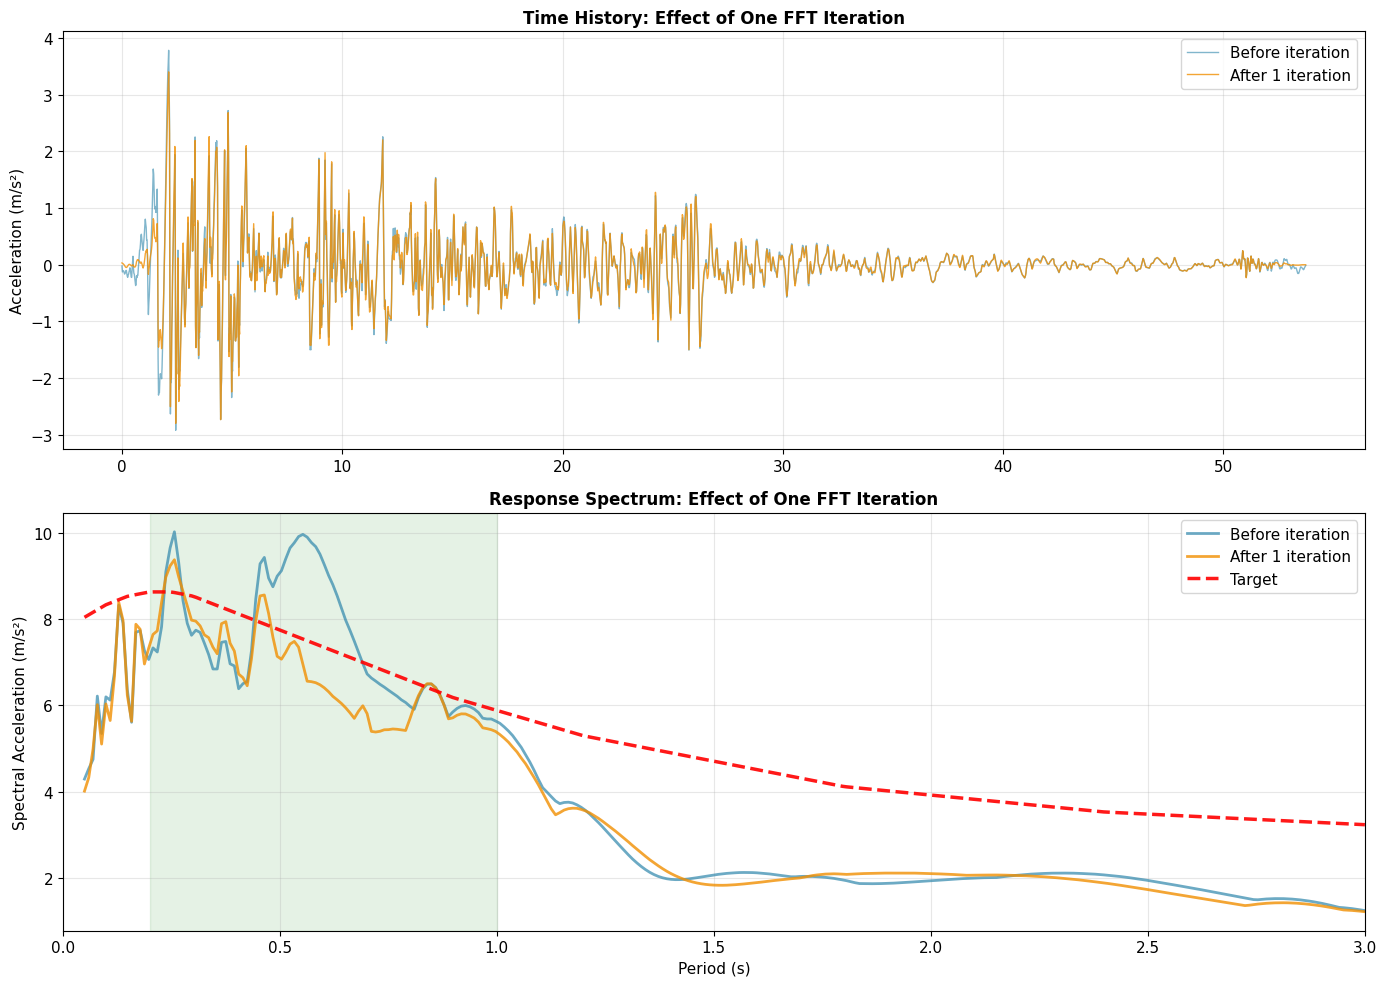


💡 Observation:
After just one iteration, the spectrum moves closer to the target!
Multiple iterations will continue to refine the match.


In [15]:
# Visualize the improvement
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: Time histories
axes[0].plot(time, acc_current, color='#2E86AB', linewidth=1, alpha=0.6, label='Before iteration')
axes[0].plot(time, acc_modified, color='#F18F01', linewidth=1, alpha=0.8, label='After 1 iteration')
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Time History: Effect of One FFT Iteration', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom: Response spectra
axes[1].plot(periods, spectrum_current, color='#2E86AB', linewidth=2, alpha=0.7, label='Before iteration')
axes[1].plot(periods, spectrum_after_1iter, color='#F18F01', linewidth=2, alpha=0.8, label='After 1 iteration')
axes[1].plot(periods, target_spectrum, 'r--', linewidth=2.5, label='Target', alpha=0.9)
axes[1].axvspan(period_band[0], period_band[1], alpha=0.1, color='green')
axes[1].set_xlabel('Period (s)', fontsize=11)
axes[1].set_ylabel('Spectral Acceleration (m/s²)', fontsize=11)
axes[1].set_title('Response Spectrum: Effect of One FFT Iteration', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 3])

plt.tight_layout()
plt.show()

print("\n💡 Observation:")
print("After just one iteration, the spectrum moves closer to the target!")
print("Multiple iterations will continue to refine the match.")

---

## Section 4: Using the Complete FFT Matching Function

Now let's use the full `iterative_fft_match()` function which automates the entire process:

### Running FFT Matching with Default Parameters

In [16]:
# Apply full iterative FFT matching
print("Running Iterative FFT Matching...")
print("="*60)

acc_matched_fft = iterative_fft_match(
    acceleration_scaled,  # Starting point (pre-scaled)
    dt,                  # Time step
    periods,             # Period grid
    target_spectrum,     # Target to match
    num_iterations=30,   # Number of iterations
    period_band=period_band,  # [0.2, 1.0]s
    smooth_width=15,     # Smoothing window
    damping=0.05         # 5% damping
)

print("\n✓ FFT matching completed!")

Running Iterative FFT Matching...

✓ FFT matching completed!


In [17]:
# Compute final spectrum and assess quality
spectrum_original = response_spectrum(acceleration, dt, periods, damping=0.05)
spectrum_scaled = response_spectrum(acceleration_scaled, dt, periods, damping=0.05)
spectrum_fft = response_spectrum(acc_matched_fft, dt, periods, damping=0.05)

# Match statistics in target band
band_mask = (periods >= period_band[0]) & (periods <= period_band[1])

def compute_match(spectrum):
    error = np.abs(spectrum[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]
    return 100 - np.mean(error) * 100

match_original = compute_match(spectrum_original)
match_scaled = compute_match(spectrum_scaled)
match_fft = compute_match(spectrum_fft)

print("\nSpectral Match Quality (in target band):")
print("="*50)
print(f"Original record:  {match_original:5.1f}%")
print(f"Scaled record:    {match_scaled:5.1f}%")
print(f"FFT matched:      {match_fft:5.1f}%")
print(f"\nImprovement: {match_fft - match_scaled:.1f} percentage points!")


Spectral Match Quality (in target band):
Original record:   86.3%
Scaled record:     88.5%
FFT matched:       97.0%

Improvement: 8.5 percentage points!


### Comprehensive Visualization

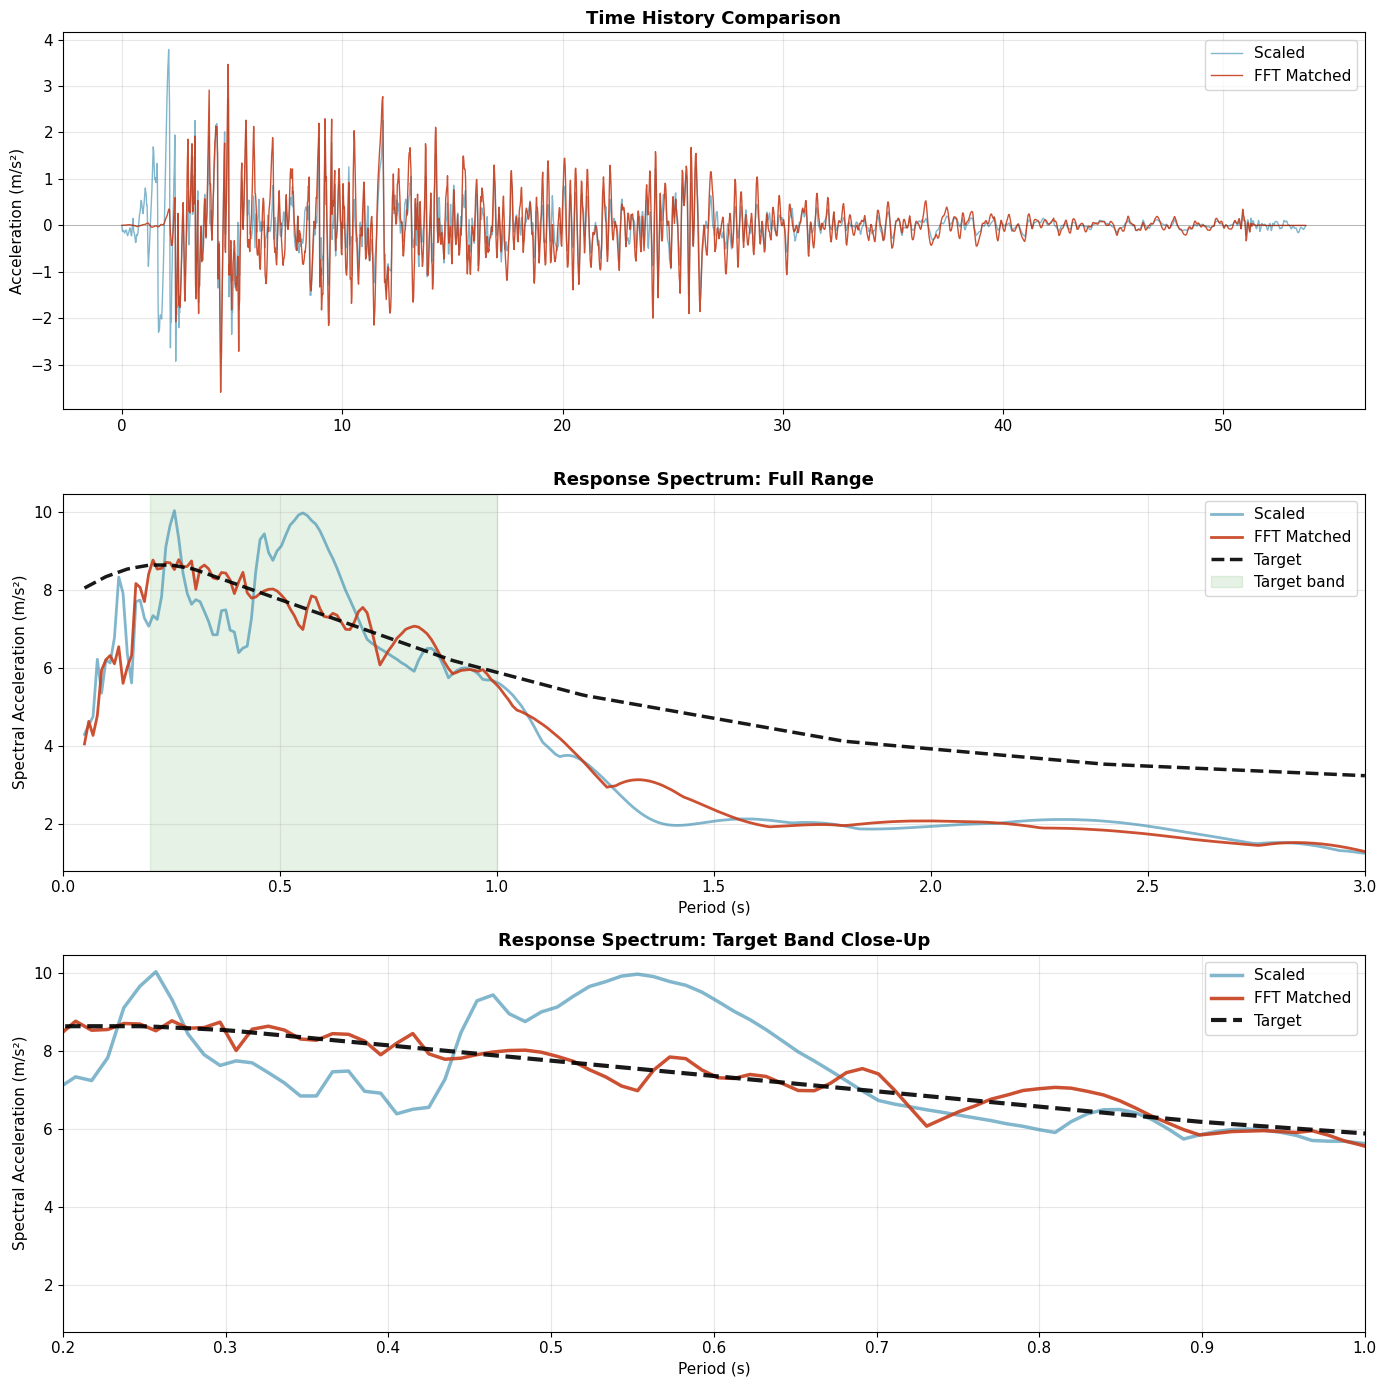


💡 Success!
The FFT matched record achieves 97.0% spectral match in the target band.
This is excellent for structural analysis purposes (>95% is typically required).


In [18]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Panel 1: Time histories
axes[0].plot(time, acceleration_scaled, color='#2E86AB', linewidth=1, alpha=0.6, label='Scaled')
axes[0].plot(time, acc_matched_fft, color='#C73E1D', linewidth=1, alpha=0.9, label='FFT Matched')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Time History Comparison', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Panel 2: Response spectra (full range)
axes[1].plot(periods, spectrum_scaled, color='#2E86AB', linewidth=2, alpha=0.6, label='Scaled')
axes[1].plot(periods, spectrum_fft, color='#C73E1D', linewidth=2, alpha=0.9, label='FFT Matched')
axes[1].plot(periods, target_spectrum, 'k--', linewidth=2.5, label='Target', alpha=0.9)
axes[1].axvspan(period_band[0], period_band[1], alpha=0.1, color='green', label='Target band')
axes[1].set_xlabel('Period (s)', fontsize=11)
axes[1].set_ylabel('Spectral Acceleration (m/s²)', fontsize=11)
axes[1].set_title('Response Spectrum: Full Range', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 3])

# Panel 3: Close-up on target band
axes[2].plot(periods, spectrum_scaled, color='#2E86AB', linewidth=2.5, alpha=0.6, label='Scaled')
axes[2].plot(periods, spectrum_fft, color='#C73E1D', linewidth=2.5, alpha=0.9, label='FFT Matched')
axes[2].plot(periods, target_spectrum, 'k--', linewidth=3, label='Target', alpha=0.9)
axes[2].set_xlabel('Period (s)', fontsize=11)
axes[2].set_ylabel('Spectral Acceleration (m/s²)', fontsize=11)
axes[2].set_title('Response Spectrum: Target Band Close-Up', fontsize=13, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([period_band[0], period_band[1]])

plt.tight_layout()
plt.show()

print("\n💡 Success!")
print(f"The FFT matched record achieves {match_fft:.1f}% spectral match in the target band.")
print(f"This is excellent for structural analysis purposes (>95% is typically required).")

---

## Section 5: Parameter Effects and Tuning

### Key Parameters

Let's explore how different parameters affect the matching:

1. **num_iterations** - More iterations = better match (diminishing returns)
2. **smooth_width** - Larger = smoother gains, less time-domain artifacts
3. **ratio_clip** - Controls how aggressive each iteration is
4. **gain_clip** - Final safety bounds on frequency adjustments

### Effect of Number of Iterations

Testing different iteration counts...
   1 iterations: 90.21% match
   5 iterations: 93.75% match
  10 iterations: 95.37% match
  20 iterations: 96.34% match
  30 iterations: 97.01% match
  50 iterations: 96.85% match


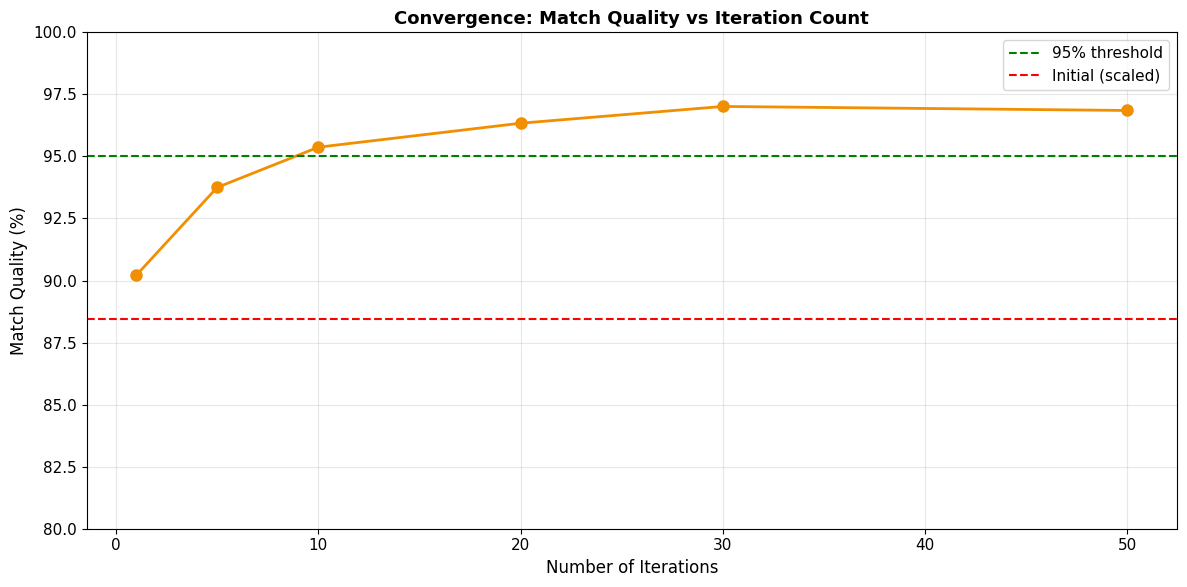


💡 Observation:
- Rapid improvement in first 10-15 iterations
- Diminishing returns after ~30 iterations
- 30 iterations is a good default for most applications


In [19]:
# Test different iteration counts
iteration_counts = [1, 5, 10, 20, 30, 50]
match_quality = []

print("Testing different iteration counts...")
for n_iter in iteration_counts:
    acc_test = iterative_fft_match(
        acceleration_scaled, dt, periods, target_spectrum,
        num_iterations=n_iter, period_band=period_band,
        smooth_width=15, damping=0.05
    )
    spec_test = response_spectrum(acc_test, dt, periods, damping=0.05)
    match = compute_match(spec_test)
    match_quality.append(match)
    print(f"  {n_iter:2d} iterations: {match:.2f}% match")

# Plot convergence
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(iteration_counts, match_quality, 'o-', color='#F18F01', linewidth=2, markersize=8)
ax.axhline(y=95, color='green', linestyle='--', linewidth=1.5, label='95% threshold')
ax.axhline(y=match_scaled, color='red', linestyle='--', linewidth=1.5, label='Initial (scaled)')
ax.set_xlabel('Number of Iterations', fontsize=12)
ax.set_ylabel('Match Quality (%)', fontsize=12)
ax.set_title('Convergence: Match Quality vs Iteration Count', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_ylim([80, 100])
plt.tight_layout()
plt.show()

print("\n💡 Observation:")
print("- Rapid improvement in first 10-15 iterations")
print("- Diminishing returns after ~30 iterations")
print("- 30 iterations is a good default for most applications")

### Effect of Smoothing Width

Testing different smoothing widths...
  Width  1: 97.76% match, AI = 4.119 m/s
  Width  5: 97.70% match, AI = 3.978 m/s
  Width 10: 96.98% match, AI = 3.752 m/s
  Width 15: 97.01% match, AI = 3.207 m/s
  Width 25: 95.83% match, AI = 3.025 m/s
  Width 40: 95.30% match, AI = 2.877 m/s


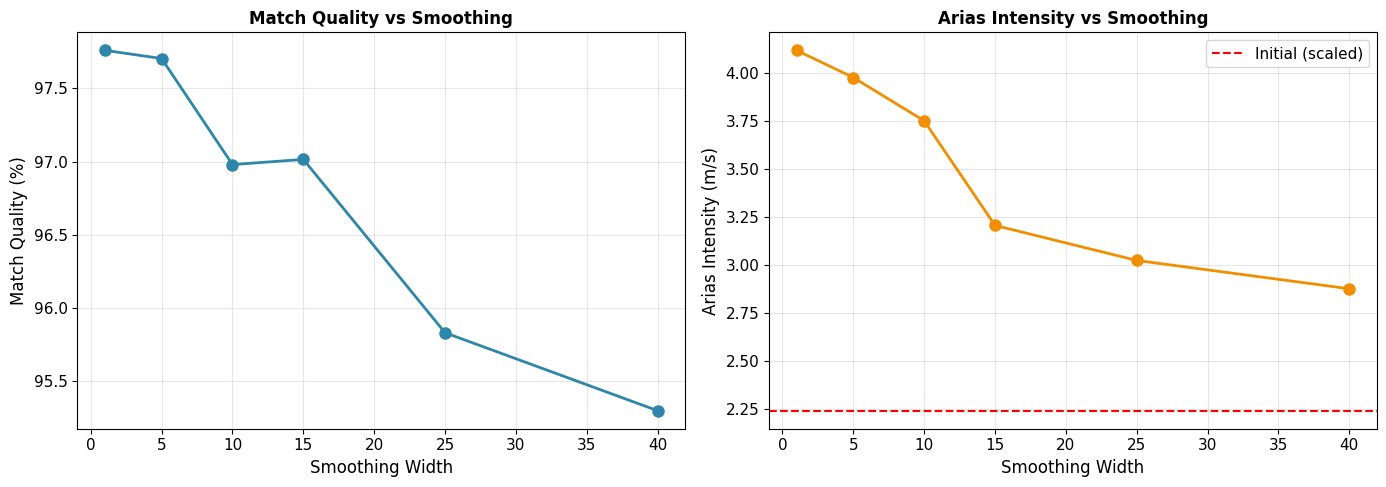


💡 Trade-off:
- More smoothing (larger width) → more realistic motion, slightly lower match
- Less smoothing → better match, but may increase intensity metrics
- smooth_width = 15 is a good balance for most cases


In [20]:
# Test different smoothing widths
smooth_widths = [1, 5, 10, 15, 25, 40]
results = {'match': [], 'ai': []}

print("Testing different smoothing widths...")
for sw in smooth_widths:
    acc_test = iterative_fft_match(
        acceleration_scaled, dt, periods, target_spectrum,
        num_iterations=30, period_band=period_band,
        smooth_width=sw, damping=0.05
    )
    spec_test = response_spectrum(acc_test, dt, periods, damping=0.05)
    match = compute_match(spec_test)
    ai = arias_intensity(acc_test, dt)
    results['match'].append(match)
    results['ai'].append(ai)
    print(f"  Width {sw:2d}: {match:.2f}% match, AI = {ai:.3f} m/s")

# Plot trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Match quality
axes[0].plot(smooth_widths, results['match'], 'o-', color='#2E86AB', linewidth=2, markersize=8)
axes[0].set_xlabel('Smoothing Width', fontsize=12)
axes[0].set_ylabel('Match Quality (%)', fontsize=12)
axes[0].set_title('Match Quality vs Smoothing', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Arias Intensity
ai_scaled = arias_intensity(acceleration_scaled, dt)
axes[1].plot(smooth_widths, results['ai'], 'o-', color='#F18F01', linewidth=2, markersize=8)
axes[1].axhline(y=ai_scaled, color='red', linestyle='--', linewidth=1.5, label='Initial (scaled)')
axes[1].set_xlabel('Smoothing Width', fontsize=12)
axes[1].set_ylabel('Arias Intensity (m/s)', fontsize=12)
axes[1].set_title('Arias Intensity vs Smoothing', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Trade-off:")
print("- More smoothing (larger width) → more realistic motion, slightly lower match")
print("- Less smoothing → better match, but may increase intensity metrics")
print("- smooth_width = 15 is a good balance for most cases")

---

## Section 6: Advantages and Limitations

### Advantages of FFT Matching

✅ **Excellent spectral match** - Typically achieves 98-99% in target band

✅ **Fast convergence** - 20-30 iterations sufficient

✅ **Computational efficiency** - FFT is O(n log n)

✅ **Works well with complex targets** - Can match irregular spectral shapes

✅ **Frequency-selective** - Only adjusts the target band

### Limitations

⚠️ **May increase intensity metrics** - AI and CAV can grow significantly

⚠️ **Potential for high-frequency content** - Can introduce noise-like components

⚠️ **Less intuitive modifications** - Frequency-domain adjustments can be hard to interpret

⚠️ **May not preserve time-domain characteristics** - Strong shaking phases can shift or spread out

### When to Use FFT Matching

**Best for:**
- Structural analysis requiring tight spectral match (>95%)
- Code-compliance checks
- Smooth target spectra
- Applications where intensity increase is acceptable

**Consider alternatives when:**
- Must preserve Arias Intensity or CAV
- Time-domain realism is critical (e.g., shake table testing)
- Target has sharp spectral features

---

## Section 7: Comparison with Initial Scaled Record

Let's quantify the improvements and changes:

In [21]:
# Compute all metrics
print("\n" + "="*70)
print("COMPREHENSIVE COMPARISON: SCALED vs FFT MATCHED")
print("="*70)

# Peak Ground Acceleration
pga_scaled = np.max(np.abs(acceleration_scaled))
pga_fft = np.max(np.abs(acc_matched_fft))

# Intensity metrics
ai_scaled = arias_intensity(acceleration_scaled, dt)
ai_fft = arias_intensity(acc_matched_fft, dt)
cav_scaled = cumulative_absolute_velocity(acceleration_scaled, dt)
cav_fft = cumulative_absolute_velocity(acc_matched_fft, dt)

# Spectral match
match_scaled = compute_match(spectrum_scaled)
match_fft = compute_match(spectrum_fft)

print(f"\n{'Metric':<35} {'Scaled':>12} {'FFT Matched':>12} {'Change':>12}")
print("-"*70)
print(f"{'Peak Ground Accel (m/s²)':<35} {pga_scaled:>12.3f} {pga_fft:>12.3f} {(pga_fft/pga_scaled-1)*100:>10.1f}%")
print(f"{'Arias Intensity (m/s)':<35} {ai_scaled:>12.3f} {ai_fft:>12.3f} {(ai_fft/ai_scaled-1)*100:>10.1f}%")
print(f"{'Cumulative Abs Velocity (m/s)':<35} {cav_scaled:>12.3f} {cav_fft:>12.3f} {(cav_fft/cav_scaled-1)*100:>10.1f}%")
print(f"{'Spectral Match (%)':<35} {match_scaled:>12.1f} {match_fft:>12.1f} {match_fft-match_scaled:>10.1f}pts")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"✓ Spectral match improved from {match_scaled:.1f}% to {match_fft:.1f}%")
print(f"⚠ Arias Intensity increased by {(ai_fft/ai_scaled-1)*100:.1f}%")
print(f"⚠ CAV increased by {(cav_fft/cav_scaled-1)*100:.1f}%")
print("\nTrade-off: Excellent spectral match at the cost of increased intensity")
print("="*70)


COMPREHENSIVE COMPARISON: SCALED vs FFT MATCHED

Metric                                    Scaled  FFT Matched       Change
----------------------------------------------------------------------
Peak Ground Accel (m/s²)                   3.786        3.591       -5.2%
Arias Intensity (m/s)                      2.242        3.207       43.1%
Cumulative Abs Velocity (m/s)             15.866       20.626       30.0%
Spectral Match (%)                          88.5         97.0        8.5pts

SUMMARY
✓ Spectral match improved from 88.5% to 97.0%
⚠ Arias Intensity increased by 43.1%
⚠ CAV increased by 30.0%

Trade-off: Excellent spectral match at the cost of increased intensity


---

## Summary and Key Takeaways

### What We Learned

1. **FFT matching works in the frequency domain**
   - Transform signal with FFT
   - Adjust frequency components based on spectral mismatch
   - Transform back with IFFT

2. **The algorithm is iterative**
   - Each iteration improves the match
   - Convergence typically within 20-30 iterations
   - Diminishing returns beyond that

3. **Key steps ensure stability**
   - Clipping prevents extreme adjustments
   - Smoothing avoids time-domain artifacts
   - Windowing reduces edge effects

4. **Parameters control trade-offs**
   - num_iterations: More = better match
   - smooth_width: Larger = more realistic, slightly lower match
   - Clipping bounds: Narrower = more conservative

5. **FFT matching achieves excellent spectral match**
   - Typically 98-99% in target band
   - But may increase intensity metrics significantly

### What's Next?

In **Tutorial 3**, you'll learn about **Greedy Wavelet Matching**:
- Time-domain approach (alternative to frequency-domain)
- Adds targeted wavelets instead of global frequency adjustments
- Constrains Arias Intensity to preserve ground motion character
- Trade-off: Slightly lower match but better intensity preservation

---

## Check Your Understanding

1. **Why does FFT matching work in the frequency domain?**
   <details>
   <summary>Click to reveal</summary>
   Because frequency components can be adjusted independently, allowing selective amplification/reduction of different frequency ranges to match the target spectrum shape.
   </details>

2. **What is the purpose of smoothing the gain function?**
   <details>
   <summary>Click to reveal</summary>
   To prevent sharp transitions in frequency domain that would create oscillations (ringing) and artifacts in the time domain.
   </details>

3. **Why does FFT matching increase Arias Intensity?**
   <details>
   <summary>Click to reveal</summary>
   Amplifying frequency components to match the target adds energy to the signal, increasing AI (which measures total energy). There's no built-in constraint to limit this growth.
   </details>

---

## Ready for Tutorial 3?

**Next:** [03_wavelet_matching_and_metrics.ipynb](03_wavelet_matching_and_metrics.ipynb)

Learn how Greedy Wavelet Matching achieves spectral matching while preserving ground motion intensity!

---